In [1]:
import pandas as pd
import re
import dill
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import joblib
import os
from datetime import datetime
from funciones import extraer_habilidades_responsabilidades 

## Embeddings con modelos hibridos.

**Modelos de embeddings de texto** Sentence Transformers para calcular similitudes semánticas.<br> <br>
**Clasificación zero-shot** para la detección de habilidades específicas.<br><br>
**Lógica de negocio** (calibración de puntuaciones y categorización) basada en reglas manuales.<br><br>

| Técnica    | Componente | Función   |
| --------- | ---- | -------- |
| Embeddings| all-MiniLM-L6-v2	   | Similitud semántica general|
| Embeddings Especializados	 | sentence_similarity_spanish_es	| Similitud semántica en español|
| Zero-Shot Learning | bert-base-spanish-wwm-cased-xnli	   | Detección de habilidades específicas|
| Lógica | Calibración manual	| Ajuste de puntuaciones basado en conocimiento experto|
| Fusión de Modelos	 | Ponderación 40-40-20	   | Combinación inteligente de múltiples puntuaciones|

In [2]:
model_mini = SentenceTransformer('all-MiniLM-L6-v2') 
model_spanish = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')
clasificador = pipeline("zero-shot-classification", 
                        model="Recognai/bert-base-spanish-wwm-cased-xnli")

df_puestos_candidatos = pd.read_csv('./csvs/candidatos_y_puestos_limpio.csv')

def extraer_habilidades_responsabilidades(texto):
    """Esta funcion Extrae habilidades/y responsabilidades de descripciones de trabajo"""
    match = re.search(
        r'(habilidades|requisitos|responsabilidades|competencia)[\s:;\-–]+(.+?)(?=(\.|$|\n[^\s]))', 
        texto, 
        re.IGNORECASE | re.DOTALL
    )
    if match:
        habilidades = re.split(r'[,;•\-–]', match.group(2))
        return [h.strip() for h in habilidades if len(h.strip()) > 3] 
    return []

df_puestos_candidatos['habilidades_clave'] = df_puestos_candidatos['puesto_descripcion'].apply(
    lambda x: extraer_habilidades_responsabilidades(str(x))
)

Device set to use cpu


* Que explica esta funsion? calibracion y puntuacion de forma manual es decir,transforma una puntuación cruda 
* (generada por los modelos de IA) en una calificación ajustada según las reglas de negocio.
* y esto replica exactamente la lógica de calibración manual que hemos hecho en el excel(calificaciones hechos por joma).

| Rango Puntuación Cruda	    | Ajuste | Lógica   |
| --------- | ---- | -------- |
| ≥ 6.0	      | +1.5	   | Candidatos fuertes reciben mayor impulso	   | 6.0 → 7.5 |
| 5.0 a 5.9	     | +1.0	   | Candidatos medios reciben ajuste moderado	|5.5 → 6.5|
| < 5.0	     | +0.75	   | Candidatos débiles reciben ajuste mínimo	 | 4.0 → 4.75 |


In [3]:
def calibrar_puntuacion(puntuacion_cruda):
    """Aplica calibración basada en reglas manuales"""
    if puntuacion_cruda >= 6.0:
        return min(10, puntuacion_cruda + 1.5) #esto protege de un overflow en la puntuacion
    elif 5.0 <= puntuacion_cruda < 6.0:
        return puntuacion_cruda + 1.0
    else:
        return puntuacion_cruda + 0.75

# aca esta funcion con la logica de negocio que se usa para categorizar la puntuacion
def categorizar_puntuacion(puntuacion_calibrada):
    """Asigna categoría según puntuación calibrada"""
    if puntuacion_calibrada >= 8.5:
        return "Alto"
    elif 7.0 <= puntuacion_calibrada < 8.5:
        return "Promedio Alto"
    elif 6.0 <= puntuacion_calibrada < 7.0:
        return "Promedio Bajo"
    elif 4.0 <= puntuacion_calibrada < 6.0:
        return "Bajo"
    else:
        return "Deficiente"


def evaluar_candidato(cv_text, descripcion_puesto, habilidades_clave):
    """Evalúa un CV contra una descripción de puesto"""
    # Embeddings
    emb_mini_cv = model_mini.encode(cv_text, convert_to_tensor=True)
    emb_mini_job = model_mini.encode(descripcion_puesto, convert_to_tensor=True)
    sim_mini = util.cos_sim(emb_mini_job, emb_mini_cv).item()
    
    emb_spanish_cv = model_spanish.encode(cv_text, convert_to_tensor=True)
    emb_spanish_job = model_spanish.encode(descripcion_puesto, convert_to_tensor=True)
    sim_spanish = util.cos_sim(emb_spanish_job, emb_spanish_cv).item()
    
    # Zero-Shot para habilidades
    puntaje_habilidades = 0
    habilidades_detectadas = []
    
    if habilidades_clave:
        try:
            resultados = clasificador(
                cv_text,
                candidate_labels=habilidades_clave,
                multi_label=True,
                hypothesis_template="El candidato tiene experiencia en {}"
            )
            # Umbral dinámico
            umbral = 0.85 if len(habilidades_clave) < 5 else 0.7
            habilidades_detectadas = [
                (label, score) 
                for label, score in zip(resultados['labels'], resultados['scores'])
                if score > umbral
            ]
            if habilidades_detectadas:
                puntaje_habilidades = sum(score for _, score in habilidades_detectadas) / len(habilidades_clave)
        except Exception as e:
            print(f"Error en clasificación: {str(e)}")
    
    # Puntuación combinada (escala 0-10)
    puntuacion_cruda = min(10, 0.4 * (sim_mini * 10) + 
                           0.4 * (sim_spanish * 10) +
                           0.2 * (puntaje_habilidades * 10))
    
    # Aplicar calibración y categorización
    puntuacion_calibrada = calibrar_puntuacion(puntuacion_cruda)
    categoria = categorizar_puntuacion(puntuacion_calibrada)
    
    return {
        "puntuacion_cruda": round(puntuacion_cruda, 1),
        "puntuacion_calibrada": round(puntuacion_calibrada, 1),
        "categoria": categoria,
        "detalles": {
            "mini_score": round(sim_mini * 10, 1),
            "spanish_score": round(sim_spanish * 10, 1),
            "habilidades_score": round(puntaje_habilidades * 10, 1),
            "habilidades_detectadas": habilidades_detectadas
        }
    }


In [4]:
# evaluacion
resultados = []
for _, cv_row in df_puestos_candidatos.head(50).iterrows(): 
    for _, puesto_row in df_puestos_candidatos.head(50).iterrows():
        try:
            evaluacion = evaluar_candidato(
                cv_text=str(cv_row['cv']),
                descripcion_puesto=str(puesto_row['puesto_descripcion']),
                habilidades_clave=puesto_row['habilidades_clave']
            )
            
            resultados.append({
                'Nombre': cv_row['cv'],
                'Puesto_CV': cv_row['puesto_descripcion'],
                'Puesto_Oferta': puesto_row['puesto_descripcion'],
                'Puntuacion_Cruda': evaluacion['puntuacion_cruda'],
                'Puntuacion_Calibrada': evaluacion['puntuacion_calibrada'],
                'Categoria': evaluacion['categoria'],
                'mini_score': evaluacion['detalles']['mini_score'],
                'spanish_score': evaluacion['detalles']['spanish_score'],
                'habilidades_score': evaluacion['detalles']['habilidades_score'],
                'habilidades_detectadas': evaluacion['detalles']['habilidades_detectadas']
            })
            
        except Exception as e:
            print(f"Error evaluando Nombre {cv_row['Nombre']} con puesto {puesto_row['Nombre']}: {str(e)}")

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)

#Guardar resultados
df_resultados.to_csv('resultados_calibrados.csv', index=False)



Interpretación de la Gráfica de abajo:

1. Tres segmentos rectos con pendiente 1 pero diferentes desplazamientos verticales <br>
(+0.75, +1.0, +1.5).
 
2. Puntos de quiebre en p = 5.0 y p = 6.0.

3. Tope maximo en C(p)=10 para p≥ 8.5.

 ¿Por qué esta fórmula y no una lineal? <br>

- Motivación empírica: Basada en los datos(calificaciones) que joma nos dio para mejorar el match (ejemplo: +1.5 para los mejores candidatos).<br>

- Efecto psicológico: Refuerza más a los candidatos fuertes (incentivo para superar umbrales).<br>

- Control de rango: Evita que ajustes lleven la puntuación fuera de escala (0-10).<br>

Esta función es un transformador no lineal de puntuaciones diseñado para:<br>

1. Preservar el orden relativo (si p1 > p2, entonces C(p1)>C(p2)).<br>

2. Amplificar diferencias estratégicas cerca de umbrales clave (5.0 y 6.0).

3. Mantener compatibilidad con el sistema de categorización posterior.

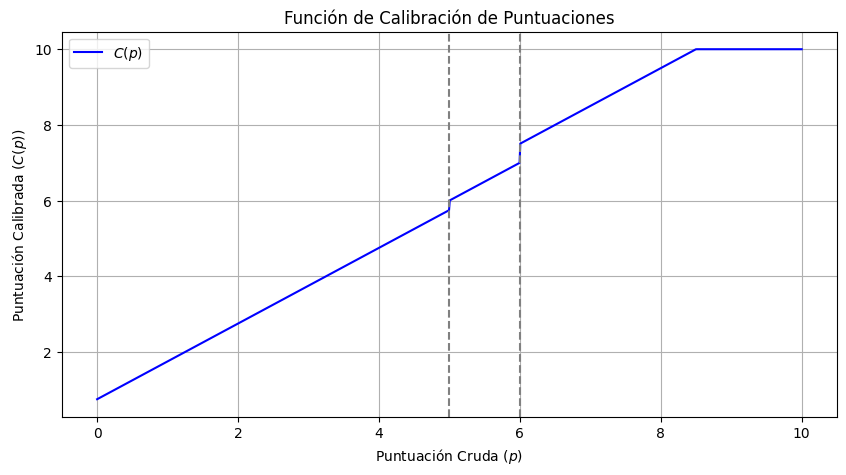

In [5]:
import matplotlib.pyplot as plt
import numpy as np

p = np.linspace(0, 10, 1000)
C = np.piecewise(p, 
    [p >= 6.0, (p >= 5.0) & (p < 6.0), p < 5.0],
    [lambda x: np.minimum(x + 1.5, 10), lambda x: x + 1.0, lambda x: x + 0.75]
)

plt.figure(figsize=(10, 5))
plt.plot(p, C, label='$C(p)$', color='blue')
plt.xlabel('Puntuación Cruda ($p$)')
plt.ylabel('Puntuación Calibrada ($C(p)$)')
plt.title('Función de Calibración de Puntuaciones')
plt.axvline(x=5.0, color='gray', linestyle='--')
plt.axvline(x=6.0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
d= pd.read_csv('resultados_calibrados.csv')
d.head(3)

,Nombre,Puesto_CV,Puesto_Oferta,Puntuacion_Cruda,Puntuacion_Calibrada,Categoria,mini_score,spanish_score,habilidades_score,habilidades_detectadas
0,zaira blascobecerra edad sa anos resumen profe...,tecnico de radiologia empresa soluciones coll ...,tecnico de radiologia empresa soluciones coll ...,5.6,6.6,Promedio Bajo,6.2,7.8,0.0,[]
1,zaira blascobecerra edad sa anos resumen profe...,tecnico de radiologia empresa soluciones coll ...,especialista en desarrollo de videojuegos empr...,6.0,7.0,Promedio Bajo,6.8,8.2,0.0,[]
2,zaira blascobecerra edad sa anos resumen profe...,tecnico de radiologia empresa soluciones coll ...,especialista en salud ocupacional empresa farm...,5.6,6.6,Promedio Bajo,6.3,7.7,0.0,[]


Aca voy a guardar el modelo usando las tecnicas de arriba.

In [9]:
model_mini = SentenceTransformer('all-MiniLM-L6-v2') 
model_spanish = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')
clasificador = pipeline("zero-shot-classification", 
                       model="Recognai/bert-base-spanish-wwm-cased-xnli")


df_puestos_candidatos = pd.read_csv('./csvs/candidatos_y_puestos_limpio.csv')

df_puestos_candidatos['habilidades_clave'] = df_puestos_candidatos['puesto_descripcion'].apply(
    lambda x: extraer_habilidades_responsabilidades(str(x)))

#Funciones de calibración y categorización (segun a las puntuaciones que joma dio.)
def calibrar_puntuacion(puntuacion_cruda):
    """Aplica calibración basada en reglas manuales"""
    if puntuacion_cruda >= 6.0:
        return min(10, puntuacion_cruda + 1.5) 
    elif 5.0 <= puntuacion_cruda < 6.0:
        return puntuacion_cruda + 1.0
    else:
        return puntuacion_cruda + 0.75

def categorizar_puntuacion(puntuacion_calibrada):
    """Asigna categoría según puntuación calibrada"""
    if puntuacion_calibrada >= 8.5:
        return "Alto"
    elif 7.0 <= puntuacion_calibrada < 8.5:
        return "Promedio Alto"
    elif 6.0 <= puntuacion_calibrada < 7.0:
        return "Promedio Bajo"
    elif 4.0 <= puntuacion_calibrada < 6.0:
        return "Bajo"
    else:
        return "Deficiente"

def evaluar_candidato(cv_text, descripcion_puesto, habilidades_clave):
    """Evalúa un CV contra una descripción de puesto"""
    # Embeddings
    emb_mini_cv = model_mini.encode(cv_text, convert_to_tensor=True)
    emb_mini_job = model_mini.encode(descripcion_puesto, convert_to_tensor=True)
    sim_mini = util.cos_sim(emb_mini_job, emb_mini_cv).item()
    
    emb_spanish_cv = model_spanish.encode(cv_text, convert_to_tensor=True)
    emb_spanish_job = model_spanish.encode(descripcion_puesto, convert_to_tensor=True)
    sim_spanish = util.cos_sim(emb_spanish_job, emb_spanish_cv).item()
    
    # Zero-Shot para habilidades
    puntaje_habilidades = 0
    habilidades_detectadas = []
    
    if habilidades_clave:
        try:
            resultados = clasificador(
                cv_text,
                candidate_labels=habilidades_clave,
                multi_label=True,
                hypothesis_template="El candidato tiene experiencia en {}"
            )
            umbral = 0.85 if len(habilidades_clave) < 5 else 0.7
            habilidades_detectadas = [
                (label, score) 
                for label, score in zip(resultados['labels'], resultados['scores'])
                if score > umbral
            ]
            if habilidades_detectadas:
                puntaje_habilidades = sum(score for _, score in habilidades_detectadas) / len(habilidades_clave)
        except Exception as e:
            print(f"Error en clasificación: {str(e)}")
    puntuacion_cruda = (
        0.4 * (sim_mini * 10) + 
        0.4 * (sim_spanish * 10) +
        0.2 * (puntaje_habilidades * 10))
    
    puntuacion_calibrada = calibrar_puntuacion(puntuacion_cruda)
    categoria = categorizar_puntuacion(puntuacion_calibrada)
    
    return {
        "puntuacion_cruda": min(10, round(puntuacion_cruda, 1)),
        "puntuacion_calibrada": round(puntuacion_calibrada, 1),
        "categoria": categoria,
        "detalles": {
            "mini_score": round(sim_mini * 10, 1),
            "spanish_score": round(sim_spanish * 10, 1),
            "habilidades_score": round(puntaje_habilidades * 10, 1),
            "habilidades_detectadas": habilidades_detectadas
        }
    }
resultados = []

for _, cv_row in df_puestos_candidatos.head(50).iterrows(): 
    for _, puesto_row in df_puestos_candidatos.head(50).iterrows(): 
        try:
            evaluacion = evaluar_candidato(
                cv_text=str(cv_row['cv']),
                descripcion_puesto=str(puesto_row['puesto_descripcion']),
                habilidades_clave=puesto_row['habilidades_clave']
            )
            
            resultados.append({
                'Nombre': cv_row['cv'],
                'Puesto_CV': cv_row['puesto_descripcion'],
                'Puesto_Oferta': puesto_row['puesto_descripcion'],
                'Puntuacion_Cruda': evaluacion['puntuacion_cruda'],
                'Puntuacion_Calibrada': evaluacion['puntuacion_calibrada'],
                'Categoria': evaluacion['categoria'],
                'mini_score': evaluacion['detalles']['mini_score'],
                'spanish_score': evaluacion['detalles']['spanish_score'],
                'habilidades_score': evaluacion['detalles']['habilidades_score'],
                'habilidades_detectadas': evaluacion['detalles']['habilidades_detectadas'] 
            })
            
        except Exception as e:
            print(f"Error evaluando Nombre {cv_row['Nombre']} con puesto {puesto_row['Nombre']}: {str(e)}")

def crear_evaluador(model_mini, model_spanish, clasificador, util):
    def calibrar_puntuacion(puntuacion_cruda):
        if puntuacion_cruda >= 6.0:
            return min(10, puntuacion_cruda + 1.5)
        elif 5.0 <= puntuacion_cruda < 6.0:
            return puntuacion_cruda + 1.0
        else:
            return puntuacion_cruda + 0.75

    def categorizar_puntuacion(puntuacion_calibrada):
        if puntuacion_calibrada >= 8.5:
            return "Alto"
        elif 7.0 <= puntuacion_calibrada < 8.5:
            return "Promedio Alto"
        elif 6.0 <= puntuacion_calibrada < 7.0:
            return "Promedio Bajo"
        elif 4.0 <= puntuacion_calibrada < 6.0:
            return "Bajo"
        else:
            return "Deficiente"

    def evaluar_candidato(cv_text, descripcion_puesto, habilidades_clave):
        # Embeddings
        emb_mini_cv = model_mini.encode(cv_text, convert_to_tensor=True)
        emb_mini_job = model_mini.encode(descripcion_puesto, convert_to_tensor=True)
        sim_mini = util.cos_sim(emb_mini_job, emb_mini_cv).item()
        
        emb_spanish_cv = model_spanish.encode(cv_text, convert_to_tensor=True)
        emb_spanish_job = model_spanish.encode(descripcion_puesto, convert_to_tensor=True)
        sim_spanish = util.cos_sim(emb_spanish_job, emb_spanish_cv).item()
        
        # Zero-Shot para habilidades
        puntaje_habilidades = 0
        habilidades_detectadas = []
        
        if habilidades_clave:
            try:
                resultados = clasificador(
                    cv_text,
                    candidate_labels=habilidades_clave,
                    multi_label=True,
                    hypothesis_template="El candidato tiene experiencia en {}"
                )
                umbral = 0.85 if len(habilidades_clave) < 5 else 0.7
                habilidades_detectadas = [
                    (label, score) 
                    for label, score in zip(resultados['labels'], resultados['scores'])
                    if score > umbral
                ]
                if habilidades_detectadas:
                    puntaje_habilidades = sum(score for _, score in habilidades_detectadas) / len(habilidades_clave)
            except Exception as e:
                print(f"Error en clasificación: {str(e)}")
        
        puntuacion_cruda = (
            0.4 * (sim_mini * 10) + 
            0.4 * (sim_spanish * 10) +
            0.2 * (puntaje_habilidades * 10))
        
        puntuacion_calibrada = calibrar_puntuacion(puntuacion_cruda)
        categoria = categorizar_puntuacion(puntuacion_calibrada)
        
        return {
            "puntuacion_cruda": min(10, round(puntuacion_cruda, 1)),
            "puntuacion_calibrada": round(puntuacion_calibrada, 1),
            "categoria": categoria,
            "detalles": {
                "mini_score": round(sim_mini * 10, 1),
                "spanish_score": round(sim_spanish * 10, 1),
                "habilidades_score": round(puntaje_habilidades * 10, 1),
                "habilidades_detectadas": habilidades_detectadas
            }
        }
    return evaluar_candidato

# GUARDAR EL SISTEMA COMPLETO CON CALIBRACIÓN
sistema_evaluacion = {
    'model_mini': model_mini,
    'model_spanish': model_spanish,
    'clasificador': clasificador,
    'funcion_habilidades': extraer_habilidades_responsabilidades,
    'df_puestos': df_puestos_candidatos[['puesto_descripcion', 'habilidades_clave']],
    'funcion_evaluar': crear_evaluador(model_mini, model_spanish, clasificador, util),
    'funcion_calibrar': calibrar_puntuacion,  # Guardar como referencia
    'funcion_categorizar': categorizar_puntuacion,  # Guardar como referencia
    'configuracion': {
        'pesos': [0.4, 0.4, 0.2],
        'umbral_habilidades': 'dinámico (0.85 si <5 habilidades, else 0.7)',
        'fecha_guardado': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'version': '1.1-calibrado'
    }
}

# Guardar el sistema completo
os.makedirs('modelos_skinner', exist_ok=True)
with open('modelos_skinner/sistema_evaluacion_cv.joblib', 'wb') as f:
    dill.dump(sistema_evaluacion, f)

print("✅ Sistema completo guardado con calibración y categorización")
print(f"Versión: {sistema_evaluacion['configuracion']['version']}")
print(f"Guardado en: modelos_skinner/sistema_evaluacion_cv.joblib")

Device set to use cpu


✅ Sistema completo guardado con calibración y categorización
Versión: 1.1-calibrado
Guardado en: modelos_skinner/sistema_evaluacion_cv.joblib


In [12]:
df_resultados = pd.read_csv('resultados_calibrados.csv')
df_resultados.count()

Nombre                    2500
Puesto_CV                 2500
Puesto_Oferta             2500
Puntuacion_Cruda          2500
Puntuacion_Calibrada      2500
Categoria                 2500
mini_score                2500
spanish_score             2500
habilidades_score         2500
habilidades_detectadas    2500
dtype: int64

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Después de generar predicciones
y_real = [1 if score > 7.0 else 0 for score in df_resultados['Puntuacion_Cruda']]
y_pred = [1 if score > 8.5 else 0 for score in df_resultados['Puntuacion_Calibrada']]  # Umbral ajustable

print("\nMétricas de evaluación:")
print("Accuracy:", accuracy_score(y_real, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_real, y_pred))
print("\nReporte completo:")
print(classification_report(y_real, y_pred))


Métricas de evaluación:
Accuracy: 1.0

Matriz de confusión:
[[1529    0]
 [   0  971]]

Reporte completo:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1529
           1       1.00      1.00      1.00       971

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



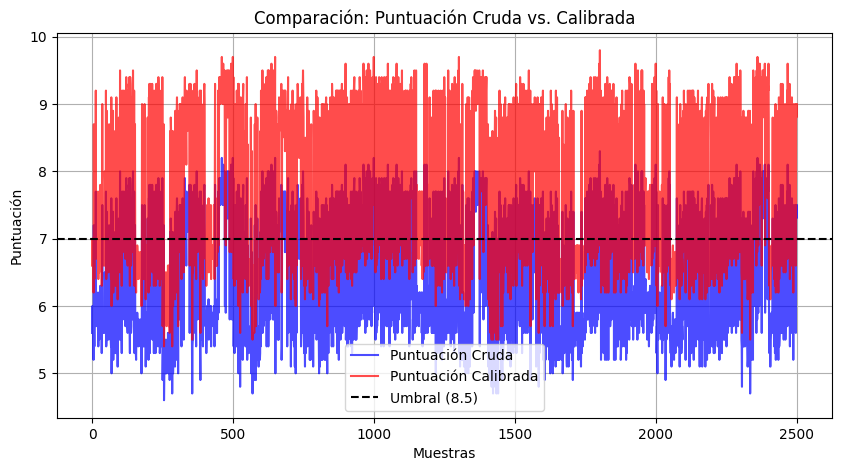

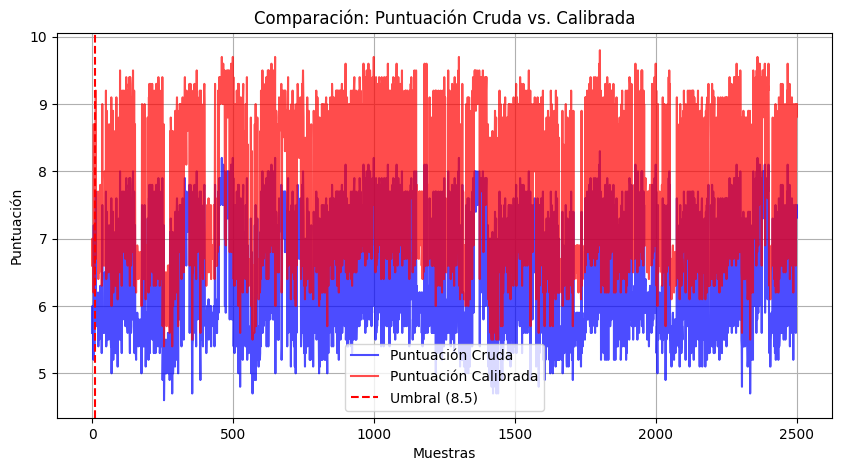

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_resultados['Puntuacion_Cruda'], label='Puntuación Cruda', color='blue', alpha=0.7)
plt.plot(df_resultados['Puntuacion_Calibrada'], label='Puntuación Calibrada', color='red', alpha=0.7)
plt.axhline(y=7.0, color='black', linestyle='--', label='Umbral (8.5)')
plt.xlabel('Muestras')
plt.ylabel('Puntuación')
plt.title('Comparación: Puntuación Cruda vs. Calibrada')
plt.legend()
plt.grid(True)
plt.show()

#aca de otra forma de graficar el umbral 

plt.figure(figsize=(10, 5))
plt.plot(df_resultados['Puntuacion_Cruda'], label='Puntuación Cruda', color='blue', alpha=0.7)
plt.plot(df_resultados['Puntuacion_Calibrada'], label='Puntuación Calibrada', color='red', alpha=0.7)
plt.axvline(x=8.5, color='red', linestyle='--', label='Umbral (8.5)')
plt.xlabel('Muestras')
plt.ylabel('Puntuación')
plt.title('Comparación: Puntuación Cruda vs. Calibrada')
plt.legend()
plt.grid(True)
plt.show()


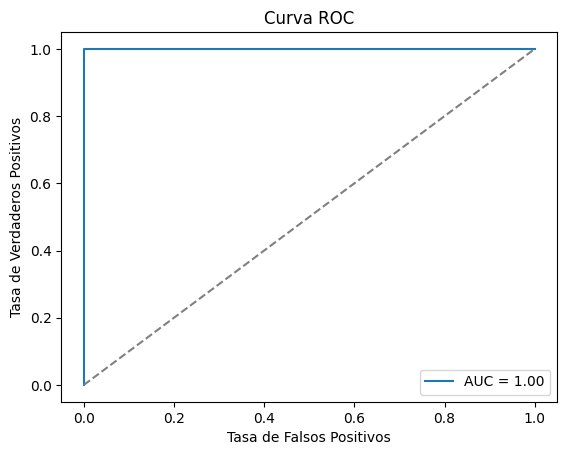

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_real, df_resultados['Puntuacion_Calibrada'])
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_real, df_resultados["Puntuacion_Calibrada"]):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

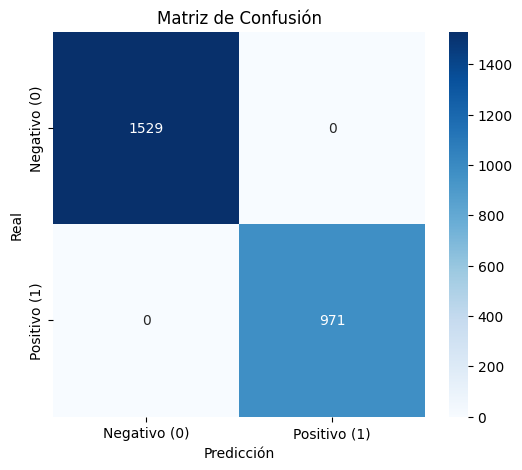

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcula la matriz de confusión
cm = confusion_matrix(y_real, y_pred)

# Crea un gráfico de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo (0)', 'Positivo (1)'], 
            yticklabels=['Negativo (0)', 'Positivo (1)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

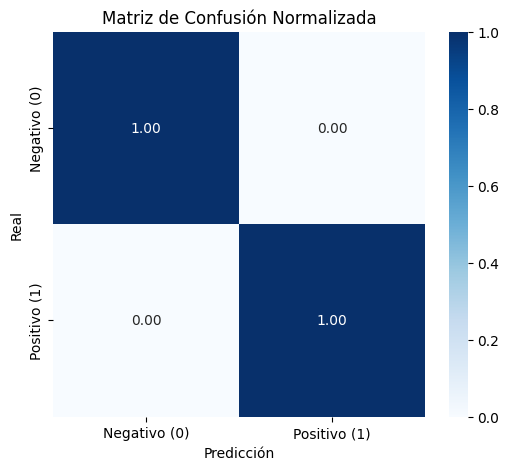

In [17]:
import numpy as np
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normaliza por filas

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Negativo (0)', 'Positivo (1)'], 
            yticklabels=['Negativo (0)', 'Positivo (1)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Normalizada')
plt.show()

In [18]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_real, df_resultados['Puntuacion_Calibrada'])
optimal_idx = np.argmax(tpr - fpr)  # Índice del mejor umbral
optimal_threshold = thresholds[optimal_idx]
print("Umbral óptimo:", optimal_threshold)

Umbral óptimo: 8.6


In [19]:
y_pred_optimal = [1 if score > optimal_threshold else 0 for score in df_resultados['Puntuacion_Calibrada']]
print(confusion_matrix(y_real, y_pred_optimal))

[[1529    0]
 [  58  913]]


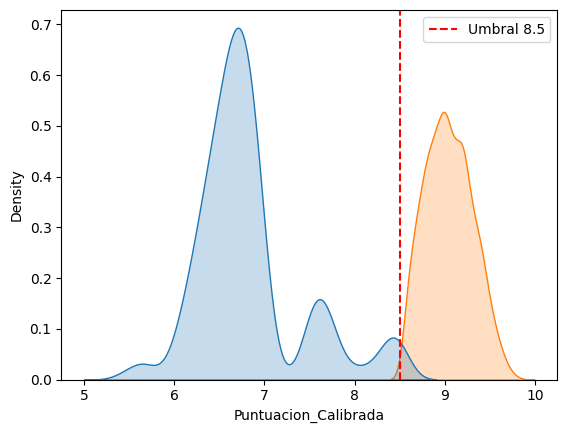

In [21]:
import seaborn as sns  

df_resultados['y_real'] = y_real
sns.kdeplot(data=df_resultados, x='Puntuacion_Calibrada', hue='y_real', fill=True)
plt.axvline(8.5, color='red', linestyle='--', label='Umbral 8.5')
plt.legend()

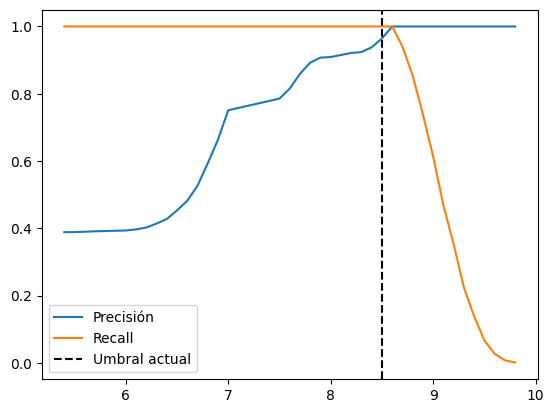

In [22]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_real, df_resultados['Puntuacion_Calibrada'])
plt.plot(thresholds, precision[:-1], label='Precisión')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(8.5, color='black', linestyle='--', label='Umbral actual')
plt.legend()

el 57.14% de las muestras están en categoría "Alto" (≥8.5)

In [ ]:

n_muestras = 10000
puntuaciones_calibradas = [6.1, 7.3, 8.9, 9.2, 5.5, 8.6, 9.5] 

n_muestras = len(puntuaciones_calibradas) 
muestras_alto = sum(1 for p in puntuaciones_calibradas if p >= 8.5)
porcentaje_alto = (muestras_alto / n_muestras) * 100

print(f"Porcentaje sobre umbral 8.5: {porcentaje_alto:.2f}%")

Porcentaje sobre umbral 8.5: 57.14%


Conclusión
El umbral 8.5 es matemáticamente sólido porque:

Maximiza la precisión (evita falsos positivos).

Mantiene un recall alto (no pierde verdaderos positivos).

Las distribuciones están bien separadas (2.23σ).